Consider a sky-diver falling towards the surface of Earth. The diver brought with them a temperature sensor that took multiple measurements along the descent. The diver is interested in determining their terminal velocity given these measurements.

Problem: Given a temperature measurement, can one estimate the velocity as a function of time?

In [1]:
using LinearAlgebra: diagm
using Random
using CairoMakie
using SymPy: Sym, @syms

CairoMakie.activate!()

include("kalmanflt.jl");
include("extendedkalmanflt.jl");

The system is a particle falling due to gravity WITH air resistance. For this simulation, the falling object will acheive terminal velocity. The velocity as a function of time is modeled as

$$
\begin{align}
v(t) &= v_{\infty} \tanh\left(\frac{g t}{v_{\infty}}\right)
\end{align}
$$

where $v_{\infty}$ is the terminal velocity as time approaches infinity and $g$ is the acceleration due to gravity. 

What we need now is a mapping between temperature and altitude.
I will use the data from https://www.engineeringtoolbox.com/air-altitude-temperature-d_461.html and linearize the temperature model. For the terminal velocity, I make-up a weak, linear relationship between temperature and terminal velocity.

$$
\begin{align}
h_{n} &= h_{n}(t) = h_{n-1} + v_{n-1} \Delta t \\
v_{n} &= v_{n}(t,\Delta t) = v_{n-1} + \frac{\partial}{\partial t}\left[v_{\infty}\tanh\left(\frac{g t}{v_{\infty}}\right)\right] \Delta t = v_{n-1} +  g \Delta t \text{sech}^2\left(\frac{g t}{v_{\infty}}\right)\\
v_{\infty} &\rightarrow v_{\infty}(T) = m_v T + b_v \\
T &\rightarrow T(h) = m_T h + b_T
\end{align}
$$

In [2]:
time_steps = 150

@syms (
    t_s::Positive, 
    T_K::Positive, 
    altitude_m::Real, 
    hnm1_m::Real, 
    hn_pred_m::Real,
    vnm1_m__s::Real, 
    time_delta_s::Positive,
    accel_m__s2::Real,
    VInf_m__s::Real,
    VInfS_m__Ks::Real,
    VInfI_m__s::Real,
    TS_K__m::Real,
    TI_K::Real
)

par_values_dict = Dict(
    time_delta_s=>0.1,
    VInfS_m__Ks=>-0.1481,
    VInfI_m__s=>94.44,
    TS_K__m=>-0.006_835,
    TI_K=>288.706,
    accel_m__s2=>-9.8,
)

Dict{Sym, Float64} with 6 entries:
  accel_m__s2  => -9.8
  VInfS_m__Ks  => -0.1481
  TI_K         => 288.706
  time_delta_s => 0.1
  TS_K__m      => -0.006835
  VInfI_m__s   => 94.44

In [3]:
fTemperature_K(altitude_m, TS_K__m, TI_K) = TS_K__m * altitude_m + TI_K
fVInf_m__s(T_K, VInfS_m__Ks, VInfI_m__s) = VInfS_m__Ks * T_K + VInfI_m__s

fVInf_m__s (generic function with 1 method)

In [4]:
vn_m__s(
    vnm1_m__s, 
    time_delta_s, 
    t_s,
    VInf_m__s,
    accel_m__s2
)  = (
    vnm1_m__s 
    + time_delta_s 
    * accel_m__s2 * sech(accel_m__s2 * t_s / VInf_m__s)^2
)

vn_m__s (generic function with 1 method)

In [5]:
hn_m(
    hnm1_m, 
    vnm1_m__s, 
    time_delta_s
) = hnm1_m + vnm1_m__s * time_delta_s

hn_m (generic function with 1 method)

In [6]:
height_state_m = StateVariable(
    hn_m, 
    hnm1_m, 
    Array([hnm1_m, vnm1_m__s, time_delta_s])
)

velocity_state_m__s = StateVariable(
    vn_m__s, 
    vnm1_m__s, 
    Array(
        [
            vnm1_m__s, 
            time_delta_s, 
            t_s, 
            fVInf_m__s(  # Velocity infty as a fcn of temperature
                fTemperature_K(  # Temperature as a fcn of altitude
                    hnm1_m, 
                    TS_K__m, 
                    TI_K
                ), 
                VInfS_m__Ks, 
                VInfI_m__s
            ), 
            accel_m__s2
        ]
    )
)

state_variables = Vector([height_state_m, velocity_state_m__s]);

In [7]:
trans_mat_sym = transition_matrix_sym(state_variables)
trans_mat_sym.doit()

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/mhogan/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


2×2 Matrix{Sym}:
                                                                                                                                                                                                                                                             1  …  time_δ_s
 2*TS_K__m*VInfS_m__Ks*accel_m__s2^2*t_s*time_delta_s*tanh(accel_m__s2*t_s/(VInfI_m__s + VInfS_m__Ks*(TI_K + TS_K__m*hnm1_m)))*sech(accel_m__s2*t_s/(VInfI_m__s + VInfS_m__Ks*(TI_K + TS_K__m*hnm1_m)))^2/(VInfI_m__s + VInfS_m__Ks*(TI_K + TS_K__m*hnm1_m))^2                1

In [8]:
plot_eval_dict = Dict(par_values_dict)

n_points = 31
time_axis_s = LinRange(0, 30, n_points)
altitude_axis_m = LinRange(2000, 3000, n_points)
dv_dh_sym = trans_mat_sym[2, 1].subs(plot_eval_dict).doit()

                            ⎛             9.8⋅tₛ             ⎞     2⎛         
-7.27924474253786e-6⋅tₛ⋅tanh⎜────────────────────────────────⎟⋅sech ⎜─────────
                            ⎝0.0010122635⋅hnm₁ ₘ + 51.6826414⎠      ⎝0.0010122
──────────────────────────────────────────────────────────────────────────────
                                                                   2          
                                   (1.95861409668586e-5⋅hnm₁ ₘ + 1)           

    9.8⋅tₛ             ⎞ 
───────────────────────⎟ 
635⋅hnm₁ ₘ + 51.6826414⎠ 
─────────────────────────
                         
                         

In [9]:
dv_dh = [
    Float64(dv_dh_sym.subs(Dict(t_s=>t, hnm1_m=>a)).evalf()) 
        for t in time_axis_s, a in altitude_axis_m
];

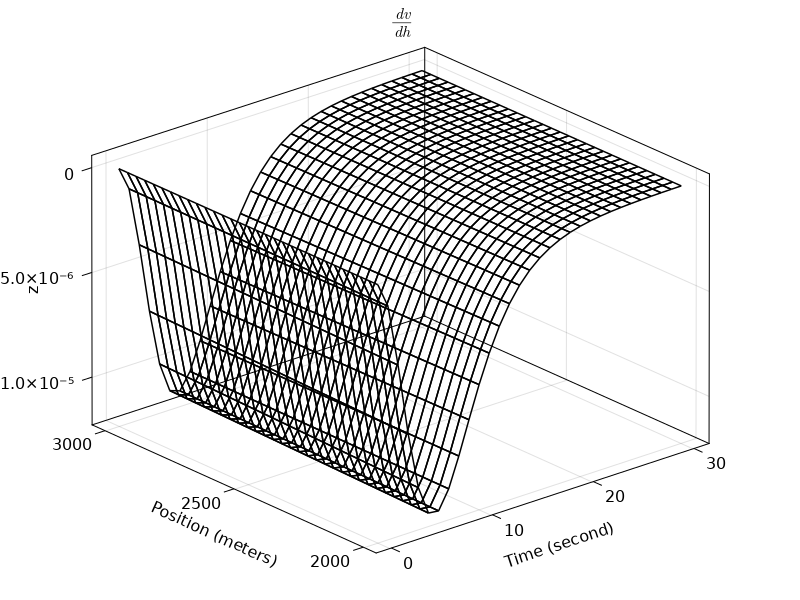

In [10]:
wireframe(
    time_axis_s,
    altitude_axis_m,
    dv_dh,
    axis=(type=Axis3, xlabel = "Time (second)", ylabel = "Position (meters)", title=L"\frac{dv}{dh}"),
    color=:black
)

current_figure()

In [11]:
temperature_obs_K(altitude_m, TS_K__m, TI_K) = fTemperature_K(altitude_m, TS_K__m, TI_K)
temperature_observation = ObservationVariable(temperature_obs_K, Array([hnm1_m, TS_K__m, TI_K]))
observation_variables = Vector([temperature_observation]);

In [12]:
obs_mat_sym = observation_matrix_sym(observation_variables, state_variables)
obs_mat_sym.doit()

1×2 Matrix{Sym}:
 TS_K__m  0

In [13]:
obs_mat = float(obs_mat_sym.subs(par_values_dict).doit().evalf())

1×2 Matrix{Float64}:
 -0.006835  0.0

In [14]:
"""Use these two variables to simulate differences variations between the truth and observation
for the temperature vs altitude
"""

"""Temperature variations"""
artificial_noise_K = 0.01  # Kelvin
observation_cov = diagm([1.0^2])  # Kelvin^2

system_noise_cov = diagm([100.0^2, 1.00^2]);

In [15]:
true_state_fcn_time = Array{Vector{Float64}}(undef, time_steps)
measurements_array = Array{Vector{Float64}}(undef, time_steps)
states_fcn_time = Array{KalmanState{Float64}}(undef, time_steps);

In [16]:
"""Define a system where a falling object is thought to be released at rest 
at 3 km above the Earth's surface with wind resistence.
"""
true_state_vector = Vector{Float64}([2915.000, -1.1])
initial_state_vector = Vector([3000.0, 0.0])
initial_state_cov = [1000.0^2 10.0; 10.0 1.0^2]  # Diagonal([100.0^2, 1.0^2])
initial_state = KalmanState{Float64}(initial_state_vector, initial_state_cov)
curr_state = KalmanState{Float64}(initial_state.state, initial_state.cov)
true_par_values_dict = Dict(par_values_dict)

for step in 1:time_steps
    
    curr_step_time_s = (step) * true_par_values_dict[time_delta_s]
    
    # Set the true parameters for this time step
    true_par_values_dict[t_s] = curr_step_time_s
    true_par_values_dict[hnm1_m] = true_state_vector[1]
    true_par_values_dict[vnm1_m__s] = true_state_vector[2]
    
    # Set the measured/estimated parameters for this time step
    par_values_dict[t_s] = curr_step_time_s
    par_values_dict[hnm1_m] = curr_state.state[1]
    par_values_dict[vnm1_m__s] = curr_state.state[2]
    
    # Calculate the true state for this simulation
    true_state_vector = Vector([
        Float64(
            var.pred_func(var.pred_func_syms...).subs(true_par_values_dict).evalf()
        ) for var in state_variables
    ])
    true_state_fcn_time[step] = true_state_vector
    
    # Predict the next state and save those predictions into the parameter dictionary
    pred_state::KalmanState = predict_state(
        state_variables, curr_state, par_values_dict, system_noise_cov
    )
    par_values_dict[hnm1_m] = pred_state.state[1]
    par_values_dict[vnm1_m__s] = pred_state.state[2]
    
    # Get the measurement
    meas_vec = Vector([
        Float64(
            var.obs_func(var.obs_func_syms...).subs(true_par_values_dict).evalf()
        ) + (randn() * artificial_noise_K) for var in observation_variables
    ])
    measurements_array[step] = meas_vec
    
    # Get the corrected current state
    # NOTE: Observation matrix "H" is evaluated+calculated automatically in "correct_state" method if none is provided
    curr_state = correct_state(
        state_variables,
        observation_variables,
        par_values_dict,
        pred_state,
        KalmanObservation{Float64}(meas_vec, obs_mat, observation_cov)
    )
    states_fcn_time[step] = curr_state
    
end

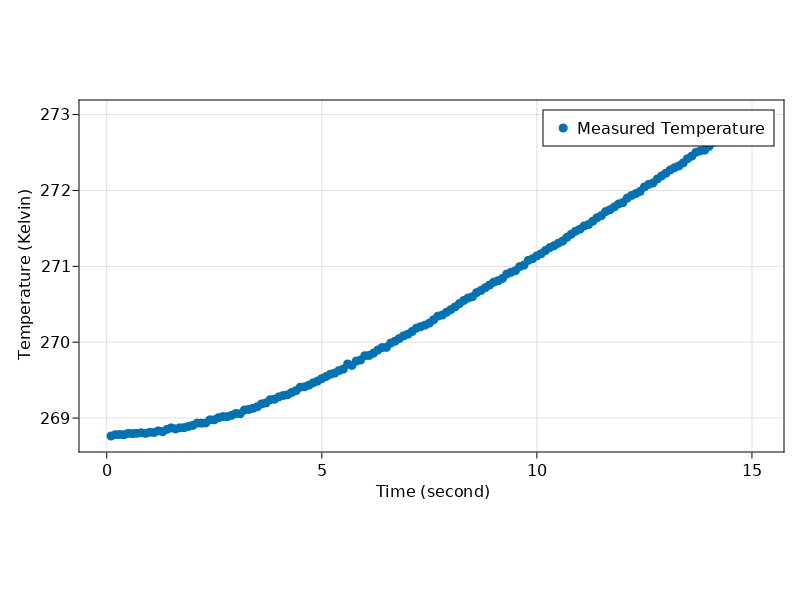

In [17]:
time_axis_s = [(step * par_values_dict[time_delta_s]) for step in 1:time_steps]
scatter(
    time_axis_s,
    [measurements_array[step][1] for step in 1:time_steps],
    axis = (aspect = 2, xlabel = "Time (second)", ylabel = "Temperature (Kelvin)"),
    label="Measured Temperature"
)
lines!(
    time_axis_s, 
    [measurements_array[step][1] for step in 1:time_steps]
)
axislegend()
current_figure()

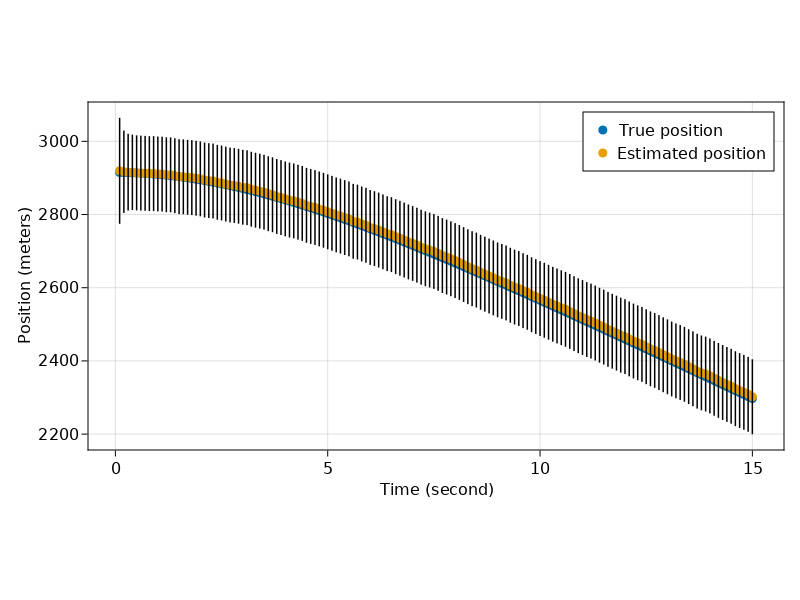

In [18]:
true_positions_m = [tr_st[1] for tr_st in true_state_fcn_time]
esti_positions_m = [s.state[1] for s in states_fcn_time]

scatter(
    time_axis_s,
    true_positions_m,
    axis = (aspect = 2, xlabel = "Time (second)", ylabel = "Position (meters)"),
    label="True position"
)

lines!(
    time_axis_s, 
    true_positions_m
)

scatter!(
    time_axis_s,
    esti_positions_m,
    label="Estimated position"
)

lines!(
    time_axis_s, 
    esti_positions_m
)

errorbars!(
    time_axis_s,
    esti_positions_m,
    [sqrt(s.cov[1, 1]) for s in states_fcn_time]
)


axislegend()
current_figure()

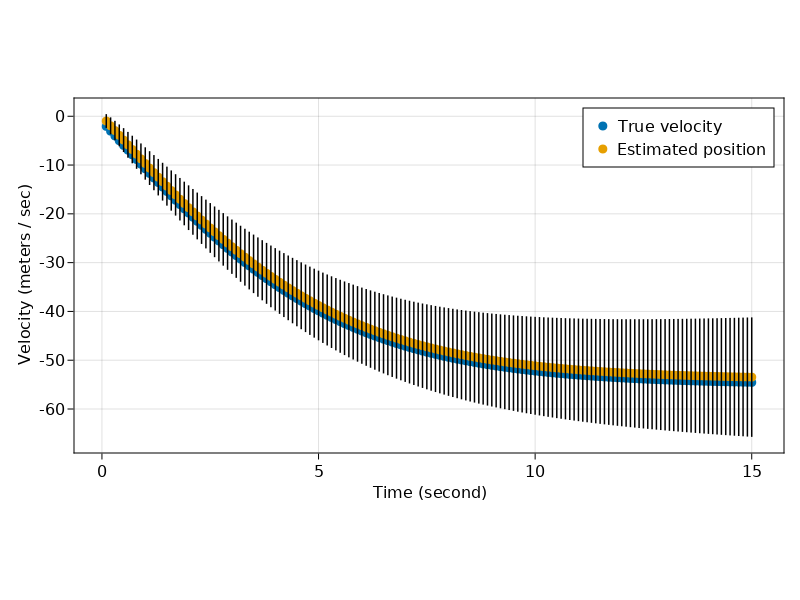

In [19]:
true_velocities_m__s = [tr_st[2] for tr_st in true_state_fcn_time]
esti_velocities_m__s = [s.state[2] for s in states_fcn_time]

scatter(
    time_axis_s,
    true_velocities_m__s,
    axis = (aspect = 2, xlabel = "Time (second)", ylabel = "Velocity (meters / sec)"),
    label="True velocity"
)

lines!(
    time_axis_s, 
    true_velocities_m__s
)

scatter!(
    time_axis_s,
    esti_velocities_m__s,
    label="Estimated position"
)

lines!(
    time_axis_s, 
    esti_velocities_m__s
)

errorbars!(
    time_axis_s,
    esti_velocities_m__s,
    [sqrt(s.cov[2, 2]) for s in states_fcn_time]
)


axislegend()
current_figure()